In [33]:
%matplotlib inline

In [83]:
import os
import time
import cv2
import numpy as np
import requests as req
import IPython
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [35]:
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [36]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [37]:
tf.__version__

'2.4.0-rc1'

Load a plug-n-play obj. detection model

In [39]:
print("Loading model...")
start_time = time.time()
detect_fn = tf.saved_model.load('../exported-models/ssd_mobilenet_v2/saved_model')
print('Done! Took {} seconds'.format(time.time()-start_time))

Loading model...
Done! Took 57.15026879310608 seconds


Load model labels

In [40]:
category_index = label_map_util.create_category_index_from_labelmap(
    '../annotations/label_map.pbtxt', 
    use_display_name=True
)

Do inference

In [41]:
#URL = 'https://www.vegvesen.no/public/webkamera/kamera?id=2580261' # 'LIVE' inference.
URL = 'https://www.vegvesen.no/public/webkamera/kamera?id=2992499'

In [47]:
def show_image(img, grayscale=False, file=None, size=(12,8)):
    plt.figure(figsize=size)
    ax = plt.subplot(111)
    if grayscale:
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)        
    else:
        plt.imshow(img)
    plt.xticks([]),plt.yticks([])
    ax.axis("off")
    plt.tight_layout()
    
    if file:
        plt.savefig('../images/temp/{}.png'.format(file))
    
    plt.show()

def get_image(url, flags=cv2.IMREAD_COLOR):
    r = req.get(url)
    if r.status_code != 200: # Is the camera down?
        return None
    img = cv2.imdecode(np.frombuffer(r.content, dtype=np.uint8), flags)
    img = img[25:,:,:] # Crop away the top black bar.
    return img, tf.convert_to_tensor(img)

def inference(image_np, input_tensor, visualize_img=False):
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    #image_np_with_detections = image_np.copy()

    start_time = time.time()
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.40,
          agnostic_mode=False
    )
    print('Inference took {} seconds'.format(time.time()-start_time))
    if visualize_img:
        show_image(image_np, size=(16,12))
        
def inference_url(url, visualize_img=False):
    image_np, input_tensor = get_image(url)
    inference(image_np, input_tensor, visualize_img)

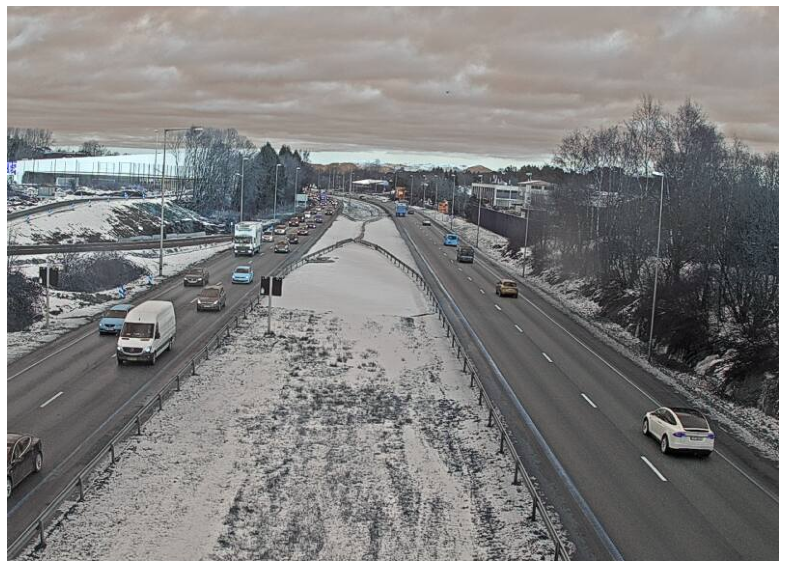

In [48]:
# Test
img, _ = get_image(URL)
show_image(img)

Inference took 0.11800694465637207 seconds


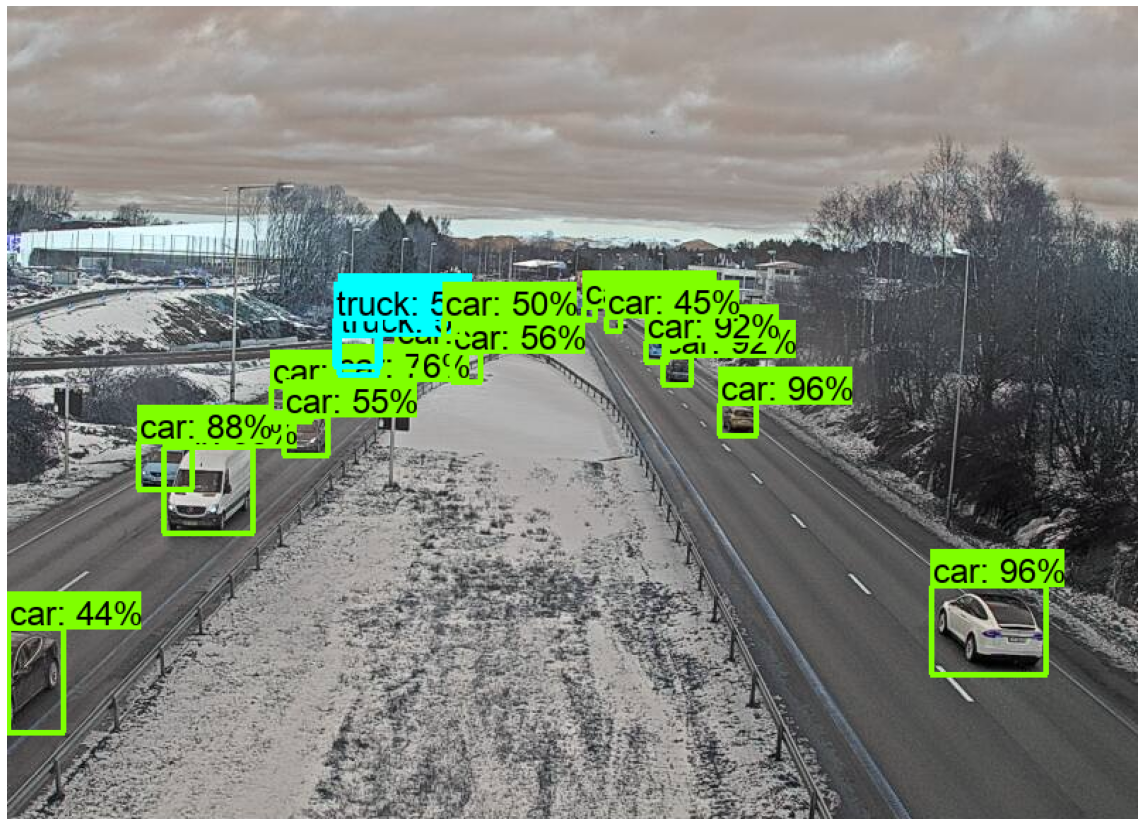

In [49]:
inference_url(URL, True)

Inference took 0.007000446319580078 seconds


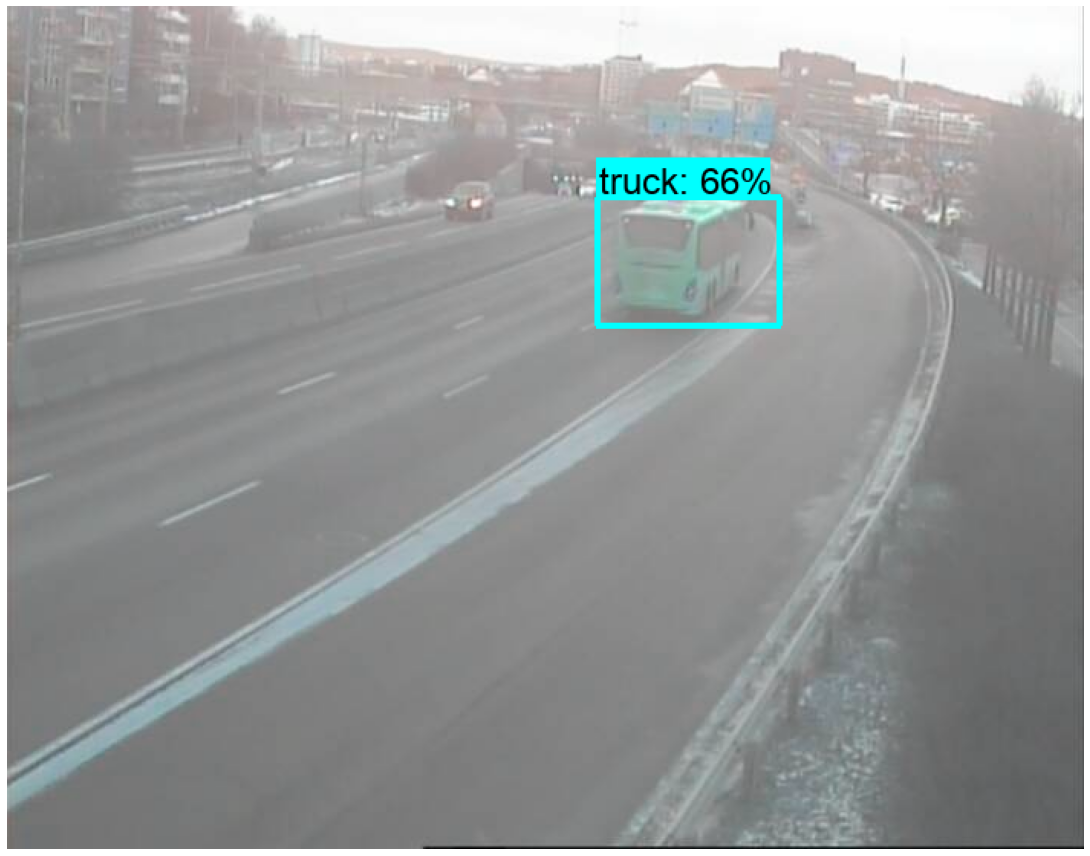

In [50]:
inference_url('https://www.vegvesen.no/public/webkamera/kamera?id=297619', True)

Inference took 0.05700325965881348 seconds


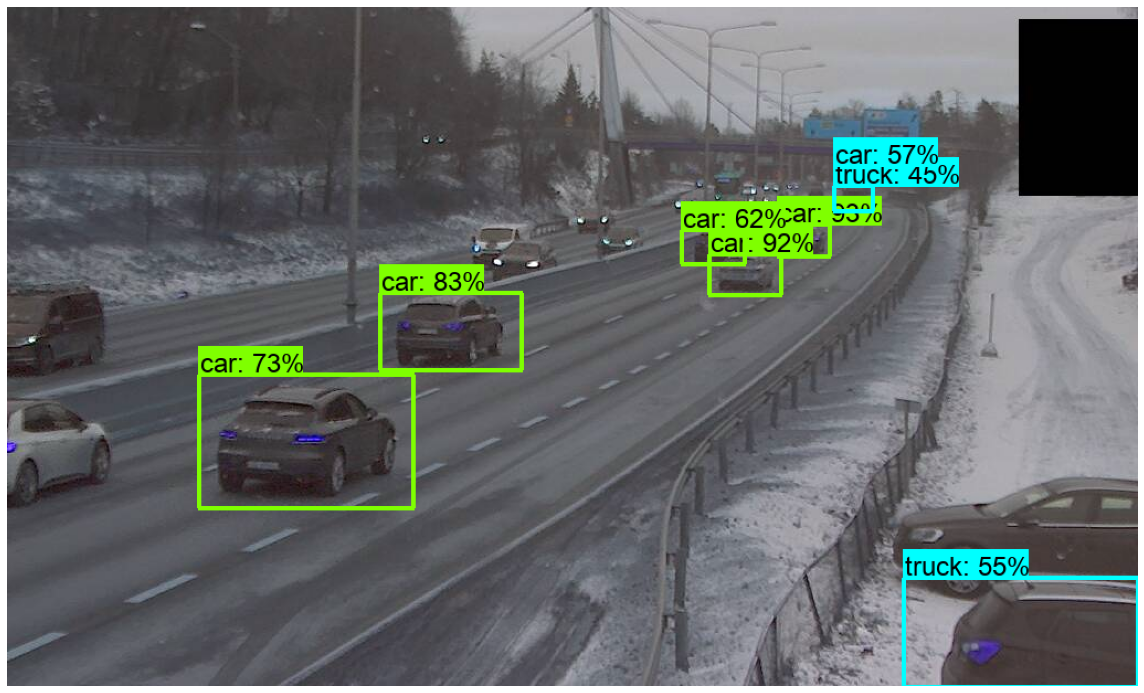

In [51]:
inference_url('https://www.vegvesen.no/public/webkamera/kamera?id=640748', True)

In [52]:
STREAM = 'https://kamera.vegvesen.no/public/0329001_1/hls_1_stream_1_orig.m3u8'

In [82]:
vstream = None
try:
    print("Started Video Stream")
    vstream = cv2.VideoCapture(None)
    vstream.open(STREAM)
    while True:
        ret, frame = vstream.read()
        if ret:
            clear_output(wait=True)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame[25:,:,:] # Crop away the top black bar.
            inference(frame, tf.convert_to_tensor(frame), False)
            IPython.display.display(Image.fromarray(frame))
        time.sleep(0.5)
except:
    print("Stopped Video Stream")
finally:
    vstream.release()

Stopped Video Stream
